In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/Neurips23/

/content/drive/MyDrive/Neurips23


In [ ]:
!ls

Integrating-Spatial-Transform-Networks-with-PaDim-Architecture	Neurips23.ipynb
mvtec_anomaly_detection.tar.xz					Neurips23-TSNET.ipynb


In [ ]:
!git clone https://github.com/renatocastro33/Integrating-Spatial-Transform-Networks-with-PaDim-Architecture.git

fatal: destination path 'Integrating-Spatial-Transform-Networks-with-PaDim-Architecture' already exists and is not an empty directory.


In [ ]:
cd Integrating-Spatial-Transform-Networks-with-PaDim-Architecture/

/content/drive/MyDrive/Neurips23/Integrating-Spatial-Transform-Networks-with-PaDim-Architecture


In [ ]:
!git checkout exp-cristian

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
!ls

Integrating-Spatial-Transform-Networks-with-PaDim-Architecture	Neurips23.ipynb
mvtec_anomaly_detection.tar.xz					Neurips23-TSNET.ipynb


In [ ]:
#!tar -xvf ../mvtec_anomaly_detection.tar.xz -C data/

In [ ]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (230 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 120899 files and directories currently install

In [ ]:
!tree -L 3 data/

data/  [error opening dir]

0 directories, 0 files


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00


In [ ]:
cd /content/drive/MyDrive/Neurips23/Integrating-Spatial-Transform-Networks-with-PaDim-Architecture/

/content/drive/MyDrive/Neurips23/Integrating-Spatial-Transform-Networks-with-PaDim-Architecture


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import timm
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.colors
from random import randint
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import glob

class TSNET_visualization:

  def __init__(self,model_name='efficientnetv2_rw_m',force=False,use_train=False):
    self.model_name = model_name
    self.use_train = use_train
    self.force = force
    # Descargar el modelo EfficientNetV2 preentrenado
    # Modelo
    self.modelo = timm.create_model(self.model_name, pretrained=True)
    self.modelo = nn.DataParallel(self.modelo)
    self.modelo.to("cuda")
    self.modelo.eval()
    #self.modelo, _ = amp.initialize(self.modelo, [])

    self.transformaciones = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

  def procesar_imagenes(self, lista_rutas, batchsize=128):

    resultados = []
    for i in tqdm(range(0, len(lista_rutas), batchsize)):

      imgs = []
      batch_rutas = lista_rutas[i:i+batchsize]

      for ruta in batch_rutas:
        img = Image.open(ruta).convert("RGB")
        img = self.transformaciones(img)
        imgs.append(img)

      imgs = torch.stack(imgs).cuda()

      with torch.no_grad():
        batch_resultados = self.modelo(imgs)

      resultados.append(batch_resultados.cpu().numpy())

    return np.concatenate(resultados)

  def obtener_caracteristicas(self,img_path):
    # Transformaciones comunes


    # Abrir imagen y convertir a RGB si está en modo diferente
    img = Image.open(img_path).convert("RGB")
    img = self.transformaciones(img)
    img = img.unsqueeze(0)

    # Desactivar gradientes
    with torch.no_grad():
        caracteristicas = self.modelo(img)

    # Convertir tensor a numpy
    return caracteristicas.numpy()

  def load_features(self):

    X_train = np.load(f'X_train_{self.model_name}.npy')
    y_train = np.load(f'y_train_{self.model_name}.npy')

    print("X_train:",X_train.shape)
    print("y_train:",y_train.shape)
    return X_train, y_train

  def save_features(self,X_train,y_train):
    X_train = np.squeeze(np.array(X_train))
    y_train = np.array(y_train)
    np.save(f'X_train_{self.model_name}.npy', X_train)
    np.save(f'y_train_{self.model_name}.npy', y_train)
    return X_train,y_train

  def processing_dataset(self,base_dir ='data'):

    # base_dir Ruta base del dataset
    # Lista para guardar features de imágenes
    X_train = []
    # Etiquetas
    y_train = []

    X_train_file_path = f'X_train_{self.model_name}.npy'
    y_train_file_path = f'y_train_{self.model_name}.npy'

    if not self.force and os.path.exists(X_train_file_path) and os.path.exists(y_train_file_path):
      X_train,y_train = self.load_features()
      return X_train, y_train

    X_train_paths = []
    # Recorrer clases
    for clase in tqdm(os.listdir(base_dir)):
        clase_dir = os.path.join(base_dir, clase)

        if os.path.isdir(clase_dir):
            print(f"{clase} es un directorio.")
        else:
            print(f"{clase} es un archivo.")
            continue


        # Imágenes de entrenamiento
        train_dir = os.path.join(clase_dir, "train")
        test_dir  = os.path.join(clase_dir, "test")


        if self.use_train:
          # Características de good
          for img in os.listdir(os.path.join(train_dir, "good")):
            path_image = os.path.join(train_dir, "good", img)
            #feature = self.obtener_caracteristicas()
            X_train_paths.append(path_image)
            y_train.append(clase+"_good")


        # Características de no_good
        for defecto in os.listdir(test_dir):
          for img in os.listdir(os.path.join(test_dir,defecto)):
            path_image = os.path.join(test_dir,defecto, img)
            #feature = self.obtener_caracteristicas(path_image)
            X_train_paths.append(path_image)
            if defecto=="good":
              y_train.append(clase+"_bad")
            else:
              y_train.append(clase+"_good")

    print("Processing inference..")
    print("X_train_paths:",len(X_train_paths))
    print("y_train:",len(y_train))
    X_train = self.procesar_imagenes(X_train_paths)
    print("Processing inference completed!")
    # Mismo proceso para test
    X_train,y_train = self.save_features(X_train,y_train)
    return X_train,y_train

  def tsnet_processing(self,X_train):
    # Reducir dimensión para visualizar
    X_train_tsne = TSNE(n_components=2).fit_transform(X_train)
    path_file = f'X_train_tsne_{self.model_name}.npy'
    if not self.force and os.path.exists(path_file):
      X_train_tsne = np.load(path_file)
      return X_train_tsne
    np.save(path_file, X_train_tsne)
    return X_train_tsne

  def visualization(self,X_train_tsne,y_train,random_colors=False):

    clases_unicas = np.unique([c.split("_")[0] for c in y_train])
    y_train = np.array(y_train)
    if random_colors:
      colores = {}
      for clase in clases_unicas:

          # Generar color hex aleatorio
          r = randint(0,255)
          g = randint(0,255)
          b = randint(0,255)


          # Asignar el color a la clase
          colores[clase] = (r,g,b)
    else:
      colores = {'bottle': (100, 39, 255),
      'cable': (169, 181, 25),
      'capsule': (116, 218, 90),
      'carpet': (184, 19, 130),
      'grid': (169, 206, 210),
      'hazelnut': (140, 39, 67),
      'leather': (5, 146, 245),
      'metal': (30, 73, 252),
      'pill': (179, 90, 151),
      'screw': (104, 148, 90),
      'tile': (228, 199, 70),
      'toothbrush': (203, 193, 69),
      'transistor': (175, 172, 119),
      'wood': (198, 42, 193),
      'zipper': (62, 45, 175)}

    plt.figure(figsize=(10,10))

    for clase in clases_unicas:

        clase_good = clase + "_good"
        print("clase:",clase_good)
        idx_good = np.where(y_train==clase_good)

        clase_bad = clase + "_bad"
        idx_bad = np.where(y_train==clase_bad)

        # Tomar color base
        r,g,b = colores[clase]
        r = max(min(255,r*13//10),0)
        g = max(min(255,g*13//10),0)
        b = max(min(255,b*13//10),0)
        hex_color = f'#{r:02x}{g:02x}{b:02x}'
        # Version oscura
        r = max(min(255,r*7//10),0)
        g = max(min(255,g*7//10),0)
        b = max(min(255,b*7//10),0)
        hex_color_dark = f'#{r:02x}{g:02x}{b:02x}'

        # Plottear ambos
        plt.scatter(X_train_tsne[idx_good, 0], X_train_tsne[idx_good, 1],label=clase, c=hex_color)
        plt.scatter(X_train_tsne[idx_bad, 0], X_train_tsne[idx_bad, 1], c=hex_color_dark)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('TSNE visualization outliers')
    plt.savefig(f'tsne_dark_{self.model_name}.png')

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

  0%|          | 0/18 [00:00<?, ?it/s]

screw es un directorio.
toothbrush es un directorio.
zipper es un directorio.
pill es un directorio.
README.md es un archivo.
bottle es un directorio.
cable es un directorio.
capsule es un directorio.
carpet es un directorio.
grid es un directorio.
hazelnut es un directorio.
leather es un directorio.
metal_nut es un directorio.
tile es un directorio.
transistor es un directorio.
wood es un directorio.
readme.txt es un archivo.
license.txt es un archivo.
Processing inference..
X_train_paths: 1725
y_train: 1725


  0%|          | 0/14 [00:00<?, ?it/s]

Processing inference completed!
(1725, 1000) (1725,)
clase: bottle_good
clase: cable_good
clase: capsule_good
clase: carpet_good
clase: grid_good
clase: hazelnut_good
clase: leather_good
clase: metal_good
clase: pill_good
clase: screw_good
clase: tile_good
clase: toothbrush_good
clase: transistor_good
clase: wood_good
clase: zipper_good


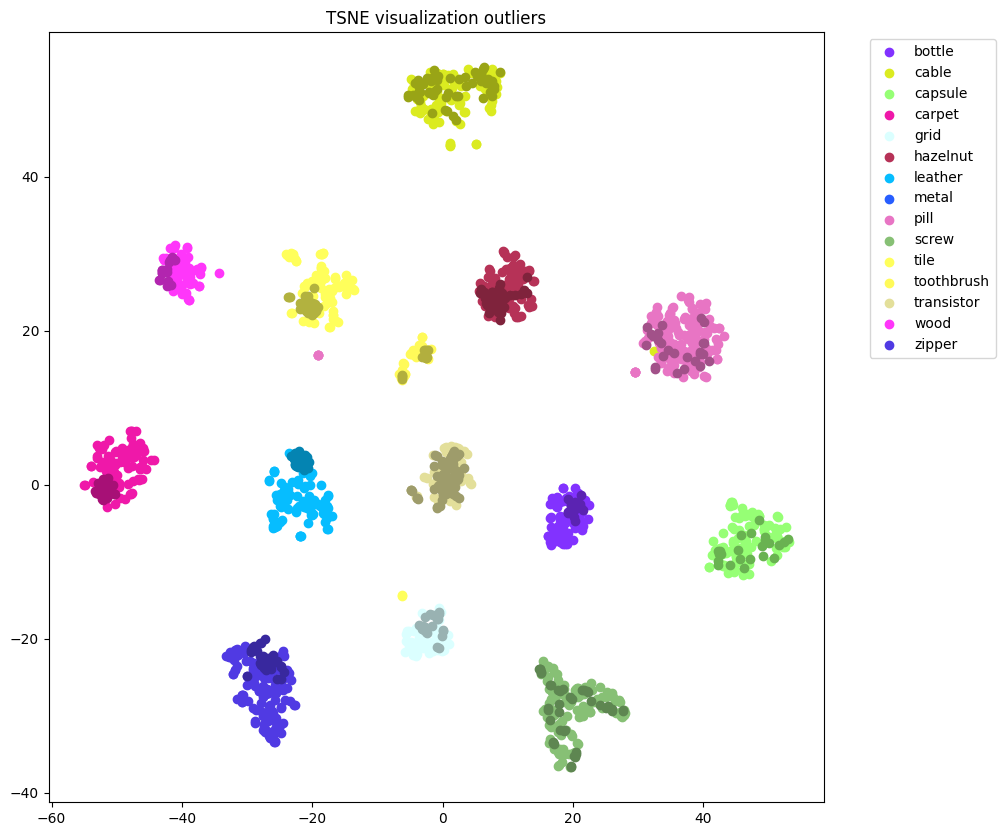

In [ ]:
#vit_base_patch16_224  ok
#resnet50.a1_in1k  ok
#resnext50_32x4d  not ok
#tf_efficientnet_b5 ok
model_tsnet = TSNET_visualization(model_name="tf_efficientnet_b5",use_train=False,force=False)
X_train,y_train = model_tsnet.processing_dataset(base_dir ='data')
print(X_train.shape,y_train.shape)
X_train_tsne = model_tsnet.tsnet_processing(X_train)
model_tsnet.visualization(X_train_tsne,y_train,random_colors=False)

In [ ]:
# Cargar y transformar imagen
data_ =  """
└── zipper
    ├── ground_truth
    │   ├── broken_teeth
    │   ├── combined
    │   ├── fabric_border
    │   ├── fabric_interior
    │   ├── rough
    │   ├── split_teeth
    │   └── squeezed_teeth
    ├── license.txt
    ├── readme.txt
    ├── test
    │   ├── broken_teeth
    │   ├── combined
    │   ├── fabric_border
    │   ├── fabric_interior
    │   ├── good
    │   ├── rough
    │   ├── split_teeth
    │   └── squeezed_teeth
    └── train
        └── good
"""
from PIL import Image
import matplotlib.pyplot as plt

img_path1 = 'data/zipper/ground_truth/broken_teeth/000_mask.png'
img1 = Image.open(img_path1)

img_path2 = 'data/zipper/test/broken_teeth/000.png'
img2 = Image.open(img_path2)

# Crear la figura con subplots
fig, axs = plt.subplots(1, 2)

# Mostrar cada imagen en un subplot
axs[0].imshow(img1)
axs[1].imshow(img2)

# Eliminar ejes
axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [ ]:
! ls data/zipper/test/broken_teeth/